In [2]:
# Preprocess raw parquet into processed wide parquets
from preprocess import prepare_from_parquet
out = prepare_from_parquet("data/raw/crypto_10_data.parquet", out_dir="data/processed",
                           atr_period=14, min_avail=0.90, ffill_limit=3, verbose=True)
# prints saved files; out contains dataframes if you want to inspect


Loading raw parquet: data/raw/crypto_10_data.parquet
Pivoting to wide tables...
Keeping 10/10 assets with availability >= 0.9
Imputing small gaps (ffill/bfill) ...
Computing log returns...
Computing ATR (period=14) and normalizing returns...
Saving processed files to: data/processed
Saved:
 - close_wide.parquet etc.
 - returns_normalized_wide.parquet
 - asset_diagnostics.parquet
Processed tickers: ['BCHUSD', 'BTCUSD', 'DOGEUSD', 'ETCUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XLMUSD', 'XMRUSD', 'XRPUSD']


d:\AIQuant\tica_alpha\preprocess.py:105: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_ff = close_wide.fillna(method="ffill", limit=ffill_limit).fillna(method="bfill", limit=ffill_limit)
d:\AIQuant\tica_alpha\preprocess.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  high_ff  = high_wide.fillna(method="ffill", limit=ffill_limit).fillna(method="bfill", limit=ffill_limit)
d:\AIQuant\tica_alpha\preprocess.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  low_ff   = low_wide.fillna(method="ffill", limit=ffill_limit).fillna(method="bfill", limit=ffill_limit)
d:\AIQuant\tica_alpha\preprocess.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffi

In [3]:
# Run the pipeline
import os
from tica_alpha import load_wide_parquet, run_backtest_pipeline, plot_cum_and_turnover
import pandas as pd
import datetime as dt

# load returns (ATR-normalized returns preferred)
returns = load_wide_parquet(processed_dir="data/processed")

# configure (tweak as needed)
WINDOW = 300
LAG_T = 9
SAVE_DIR = f"experiments/run_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}"
out = run_backtest_pipeline(returns, window=WINDOW, lag_T=LAG_T,
                            weight_alpha=0.2, ema_signal=20,
                            hyst_k=0.06, roll_vol_window=60,
                            tc=0.001, vol_target=0.30,
                            save_dir=SAVE_DIR, verbose=True)

print("Metrics:", out["metrics"])


run_backtest_pipeline: window=300, lag_T=9
tICA progress: 500/3100
tICA progress: 750/3100
tICA progress: 1000/3100
tICA progress: 1250/3100
tICA progress: 1500/3100
tICA progress: 1750/3100
tICA progress: 2000/3100
tICA progress: 2250/3100
tICA progress: 2500/3100
tICA progress: 2750/3100
tICA progress: 3000/3100
Metrics: {'ann_return': np.float64(0.15821480419789502), 'ann_vol': np.float64(0.2976071705838009), 'sharpe': np.float64(0.6420576683888134), 'max_dd': np.float64(1.809500487168974)}


In-Sample metrics:
  Ann Return: 19.44%
  Ann Vol:    29.72%
  Sharpe:     0.75
  Max DD:     138.31%

Out-of-Sample metrics:
  Ann Return: -8.00%
  Ann Vol:    30.07%
  Sharpe:     -0.13
  Max DD:     42.33%



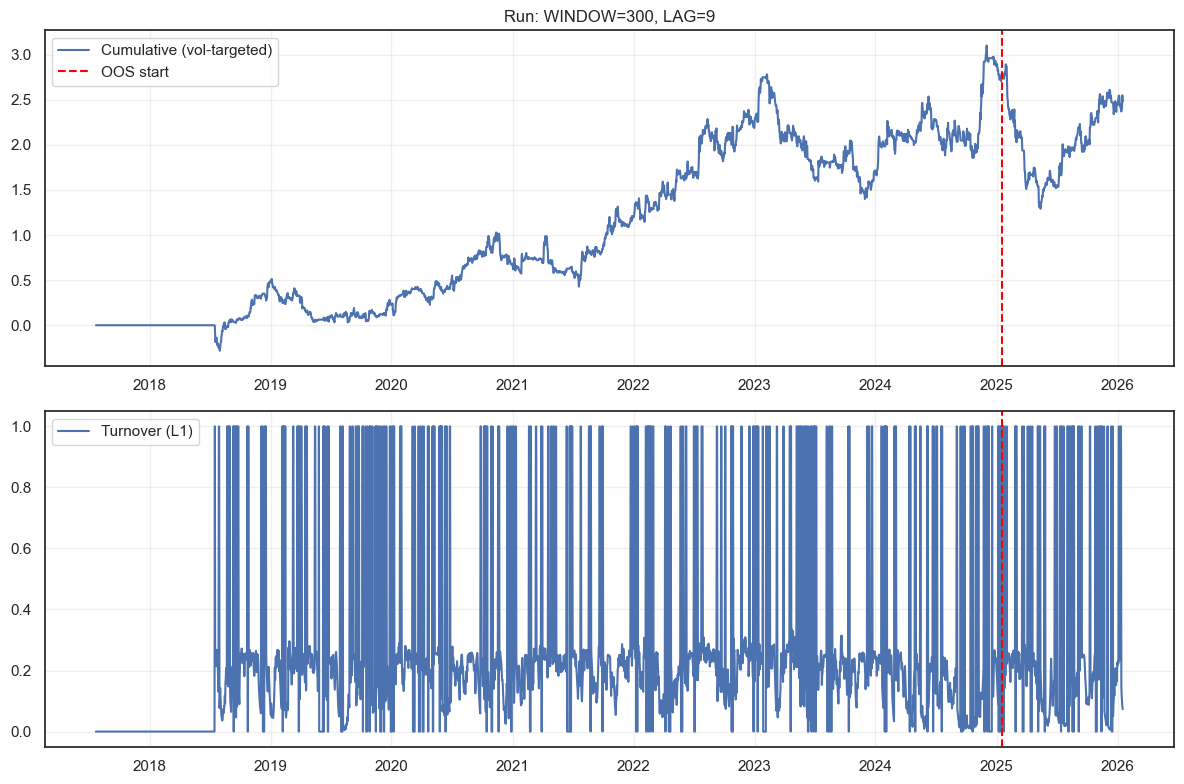

In [4]:
# Plot & show metrics / IS vs OOS
from tica_alpha import plot_cum_and_turnover, print_metrics, perf_metrics
import pandas as pd

daily_vt = out["daily_vt"]
turnover = out["turnover"]
dates = daily_vt.index
oos_start = dates[-365]  # last year as OOS

plot_cum_and_turnover(daily_vt, turnover, oos_start=oos_start, title=f"Run: WINDOW={WINDOW}, LAG={LAG_T}")

# Print IS vs OOS numbers
is_mask = daily_vt.index < oos_start
oos_mask = daily_vt.index >= oos_start

is_metrics = perf_metrics(daily_vt[is_mask])
oos_metrics = perf_metrics(daily_vt[oos_mask])
print_metrics(is_metrics, "In-Sample metrics:")
print_metrics(oos_metrics, "Out-of-Sample metrics:")


[1/25] GRID W=100 L=3 ... IS ann_ret=-15.14%, sharpe=-0.36, turn=0.289
[2/25] GRID W=100 L=5 ... IS ann_ret=8.26%, sharpe=0.41, turn=0.271
[3/25] GRID W=100 L=7 ... IS ann_ret=-5.02%, sharpe=-0.01, turn=0.279
[4/25] GRID W=100 L=9 ... IS ann_ret=-19.59%, sharpe=-0.54, turn=0.279
[5/25] GRID W=100 L=11 ... IS ann_ret=-14.02%, sharpe=-0.30, turn=0.281
[6/25] GRID W=200 L=3 ... IS ann_ret=-18.80%, sharpe=-0.53, turn=0.249
[7/25] GRID W=200 L=5 ... IS ann_ret=3.78%, sharpe=0.27, turn=0.252
[8/25] GRID W=200 L=7 ... IS ann_ret=1.12%, sharpe=0.19, turn=0.258
[9/25] GRID W=200 L=9 ... IS ann_ret=1.52%, sharpe=0.20, turn=0.261
[10/25] GRID W=200 L=11 ... IS ann_ret=-3.50%, sharpe=0.03, turn=0.277
[11/25] GRID W=300 L=3 ... IS ann_ret=-0.42%, sharpe=0.13, turn=0.224
[12/25] GRID W=300 L=5 ... IS ann_ret=-3.89%, sharpe=0.02, turn=0.236
[13/25] GRID W=300 L=7 ... IS ann_ret=-4.72%, sharpe=-0.01, turn=0.254
[14/25] GRID W=300 L=9 ... IS ann_ret=19.44%, sharpe=0.75, turn=0.248
[15/25] GRID W=300 L=

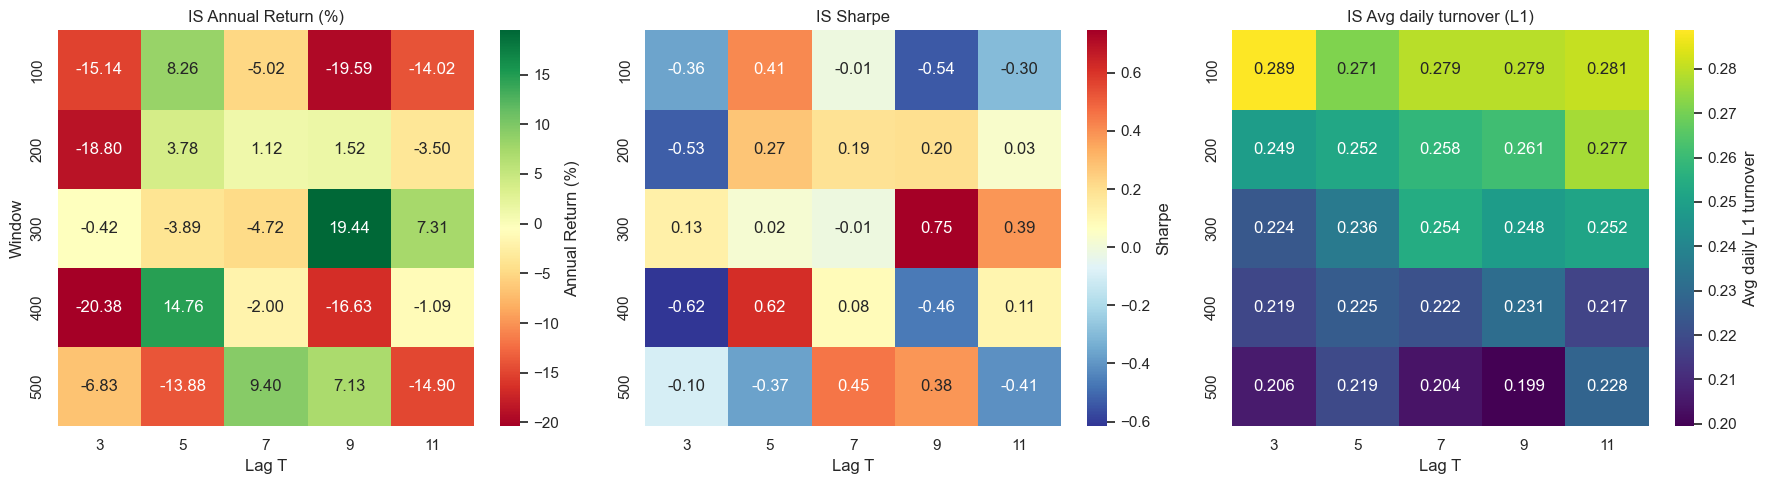

Saved grid CSVs to: experiments/grid
OOS start: 2025-01-17


In [1]:
# Run IS-only grid search and plot 3 heatmaps
import importlib
import sys
if 'tica_alpha' in sys.modules:
    importlib.reload(sys.modules['tica_alpha'])

from tica_alpha import load_wide_parquet, grid_search_tica_is, plot_grid_heatmaps
import datetime as dt
import os

# load returns (ATR-normalized) - ensure preprocess cell was run first
returns = load_wide_parquet(processed_dir="data/processed")

# grid specification
WINDOW_LIST = [100, 200, 300, 400, 500]
LAG_LIST = [3, 5, 7, 9, 11]

# quick speed control during interview/demo (use full universe normally)
MAX_ASSETS = None   # set small int like 10 if you want very fast run

# run grid (this may take time for full universe; show progress in output)
grid_res = grid_search_tica_is(returns,
                               window_list=WINDOW_LIST,
                               lag_list=LAG_LIST,
                               weight_alpha=0.2,
                               ema_signal=20,
                               hyst_k=0.06,
                               roll_vol_window=60,
                               tc=0.001,
                               vol_target=0.30,
                               reg_eps=1e-8,
                               oos_days=365,
                               max_assets=MAX_ASSETS,
                               verbose=True)

# plot heatmaps
plot_grid_heatmaps(grid_res)

# save numeric results for later review
out_dir = "experiments/grid"
os.makedirs(out_dir, exist_ok=True)
grid_res["return"].to_csv(os.path.join(out_dir, "grid_return_is.csv"))
grid_res["sharpe"].to_csv(os.path.join(out_dir, "grid_sharpe_is.csv"))
grid_res["turnover"].to_csv(os.path.join(out_dir, "grid_turnover_is.csv"))
print("Saved grid CSVs to:", out_dir)
print("OOS start:", grid_res["oos_start"].date())
